# Using a deep learning framework for auto-encoding and image colourization

JingYang Zeng and David Pomerenke

In [1]:
import math
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# online:
# from google.colab import drive
# drive.mount('/content/gdrive')
# path = '/content/gdrive/My Drive/Colab Notebooks/Framework/'
# offline:
path = 'output/'

In [3]:
# CONFIGURATION
retrain = False # Retrain or load trained model from file?
sample  = 0.1  # proportion of data to be used

## Part 1

Where we train an autoencoder with the parameters suggested in the assignment.

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [5]:
print(len(x_train), len(y_train), len(x_test), len(y_test))

50000 50000 10000 10000


In [6]:
x_all = np.concatenate([x_train, x_test])
normalized = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x_all)
cut1, cut2 = round(0.8 * len(normalized)), round(0.9 * len(normalized))
train_, validation_, test_ = normalized[:cut1], normalized[cut1:cut2], normalized[cut2:]
train, validation, test = train_[:round(len(train_)*sample)], validation_[:round(len(validation_)*sample)], test_[:round(len(test_)*sample)]
print(len(train), len(validation), len(test))

4800 600 600


In [7]:
def show(l):
    """display a list of images"""
    s = math.ceil(math.sqrt(len(l)))
    plt.figure(figsize=(2*s, 2*s))
    for i in range(len(l)):
        ax = plt.subplot(s, s, i + 1)
        plt.imshow(l[i], cmap='gray')
        plt.axis('off')

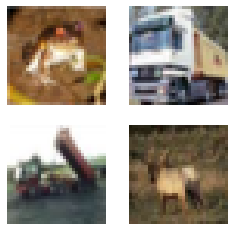

In [8]:
show(train[:4])

In [9]:
# adapted from [2], [3]

def make_model():
    """model with parameters as suggested in the assignment"""
    inputs = keras.Input(shape=(32, 32, 3))
    x = layers.Conv2D(8, 3, activation='relu', strides=1, padding='same')(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = layers.Conv2D(12, 3, activation='relu', strides=1, padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    encoded = layers.Conv2D(16, 3, activation='relu', strides=1, padding="same")(x)
    x = layers.UpSampling2D(size=(2, 2))(encoded)
    x = layers.Conv2D(12, 3, activation='relu', strides=1, padding="same")(x)
    x = layers.UpSampling2D(size=(2, 2))(x)
    decoded = layers.Conv2D(3, 3, activation='relu', strides=1, padding="same")(x)
    return keras.Model(inputs, decoded)

model = make_model()
# keras.utils.plot_model(model, show_shapes=True)

In [10]:
if retrain:
    model.compile(
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    training = model.fit(
        train,
        train, 
        epochs=10, 
        validation_data=(validation, validation)
    )
    model.save(path + 'first_model')
else:
    model = keras.models.load_model(path + 'first_model')

In [11]:
if retrain:
    plt.plot(training.history['loss'])
    plt.plot(training.history['val_loss'])
    plt.title('Evolution of the error')
    plt.ylabel('error')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'])
    plt.savefig(path + 'error_evolution_first_model.png')

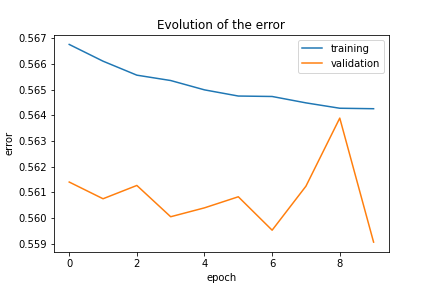

In [12]:
(loss, accuracy) = model.evaluate(test, test)
print("test error: ", loss)
print("test accuracy: ", accuracy)

19/19 [==============================] - 0s 18ms/step - loss: 0.5623 - accuracy: 0.6774
test error:  0.5623059272766113
test accuracy:  0.6773648858070374


In [13]:
def show_columns(a, b, n=3):
    """display two lists of images as 2 columns"""
    plt.figure(figsize=(5, 2.5*n))
    for i in range(n):
        ax1 = plt.subplot(n, 2, i*2 + 1)
        plt.imshow(a[i], cmap='gray')
        plt.axis('off')
        ax2 = plt.subplot(n, 2, i*2 + 2)
        plt.imshow(b[i], cmap='gray')
        plt.axis('off')

def predict_examples(model, n=3):
    """diplay"""
    predicted = model.predict(test[:n])
    show_columns(test[:n], predicted, n=n)

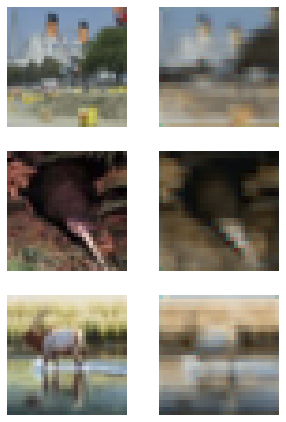

In [14]:
predict_examples(model)
plt.savefig(path + 'first.png')

The size of the latent space representation is as follows:

$\text{size}=\left(\frac{W-K+2P}{S}+1\right)^2\cdot C = \left(\frac{8-3+2\cdot 1}{1}+1\right)^2\cdot 16 = 1024$

In [15]:
def size(input_size, kernel_size, padding, stride, channels):
    return ((input_size - kernel_size + 2*padding) / stride + 1)**2 * channels

In [16]:
size(8, 3, 1, 1, 16)

1024.0

## Part 2

Where we systematically evaluate different architectures and hyperparameters.

In order to evaluate multiple architectures, we adapt our model to allow for the specification of hyperparameters and parameters with regard to the architecture:

In [17]:
def pad(kernel_size, x):
    return layers.ZeroPadding2D(padding=(int((kernel_size - 1) / 2), int((kernel_size - 1) / 2)))(x)

def conv(channel_factor, kernel_size, x):
    x = pad(kernel_size, x)
    return layers.Conv2D(channel_factor, kernel_size, activation='relu', padding='valid')(x)

def pool(factor, x):
    return layers.MaxPooling2D(pool_size=(factor, factor), padding='same')(x)

def upsample(factor, x):
    return layers.UpSampling2D(size=(factor, factor))(x)

In [18]:
def make_model_with_config(
    input_layers=3,
    output_layers=3,
    fewer_layers=False, 
    channel_factor=4, 
    kernel_size=3,
    compression_factor=2
):
    inputs = keras.Input(shape=(32, 32, input_layers))
    
    x = conv(input_layers, kernel_size, inputs)
    
    if not fewer_layers:
        x = pool(compression_factor, x)
        x = conv(3*channel_factor, kernel_size, x)

    x = pool(compression_factor, x)
    encoded = conv(4*channel_factor, kernel_size, x)

    if not fewer_layers:
        x = upsample(compression_factor, encoded)
        x = conv(3*channel_factor, kernel_size, x)
    
    x = upsample(compression_factor, x)
    decoded = conv(output_layers, kernel_size, x)

    return keras.Model(inputs, decoded)

One training at 10 epochs takes about 2 minutes, so 20 minutes for one training. A night has around $10\cdot 3\cdot 20$ minutes, so around $30\approx 36 = 2^2\cdot 3^2$ trainings.

In [ ]:
models = []
i = 1
for loss in ['binary_crossentropy']: #, 'mean_squared_error']:
    for fewer_layers in [True, False]:
        for channel_factor in [2, 4, 8]:
            for kernel_size in [3, 5]:
                for compression_factor in [1, 2, 4]:
                    if retrain:
                        print('training model ' + str(i) + ' of 36')                        
                        model = make_model_with_config(
                            fewer_layers=fewer_layers, 
                            channel_factor=channel_factor, 
                            kernel_size=kernel_size,
                            compression_factor=compression_factor
                        )
                        model.compile(
                            loss=loss,
                            metrics=['accuracy']
                        )
                        training = model.fit(
                            train,
                            train, 
                            epochs=10, 
                            validation_data=(validation, validation)
                        )
                        model.save(path + 'model_' + str(i))
                    else:
                        print('loading model ' + str(i) + ' of 36')
                        model = keras.models.load_model(path + 'model_' + str(i))
                    latent_space_size = size(
                            input_size=32 / compression_factor / (compression_factor if fewer_layers else 1),
                            kernel_size=kernel_size,
                            padding=(kernel_size - 1) / 2,
                            stride=1,
                            channels=4*channel_factor
                        )
                    models.append({
                        'loss_metric': loss,
                        'fewer_layers': fewer_layers, 
                        'channel_factor': channel_factor, 
                        'kernel_size': kernel_size, 
                        'compression_factor': compression_factor,
                        'latent_space_size': latent_space_size,
                        'model': model
                    })
                    i += 1

In [ ]:
latent_space_size = [model['latent_space_size'] for model in models]
metrics = [model['model'].evaluate(test, test) for model in models]
reconstruction_error = [metric[0] for metric in metrics]
accuracy = [metric[1] for metric in metrics]

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


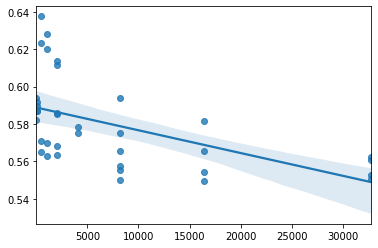

In [21]:
sns.regplot(latent_space_size, reconstruction_error)
plt.savefig(path + 'reconstruction_error_vs_latent_space_size.png')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


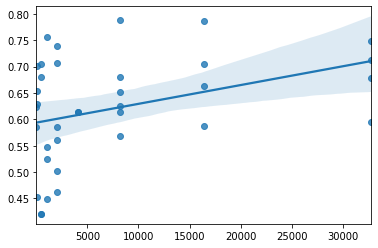

In [22]:
sns.regplot(latent_space_size, accuracy)

In [23]:
sorted_models = sorted(zip(models, accuracy), key=lambda a: a[1], reverse=True)

In [24]:
flop_configuration, flop_accuracy = sorted_models[len(sorted_models)-1]
flop_configuration

{'channel_factor': 2,
 'compression_factor': 4,
 'fewer_layers': False,
 'kernel_size': 5,
 'latent_space_size': 512.0,
 'loss_metric': 'binary_crossentropy',
 'model': <tensorflow.python.keras.engine.functional.Functional at 0x7fcf3824c3c8>}

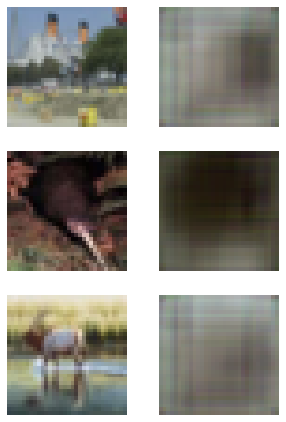

In [25]:
worst_model = flop_configuration['model']
predict_examples(worst_model)
plt.savefig(path + 'worst.png')

In [26]:
top_configuration, top_accuracy = sorted_models[0]
top_configuration

{'channel_factor': 2,
 'compression_factor': 1,
 'fewer_layers': True,
 'kernel_size': 3,
 'latent_space_size': 8192.0,
 'loss_metric': 'binary_crossentropy',
 'model': <tensorflow.python.keras.engine.functional.Functional at 0x7fcf3ad972b0>}

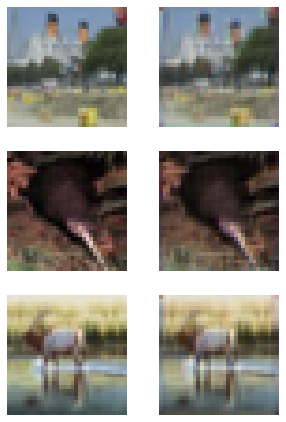

In [27]:
best_model = top_configuration['model']
predict_examples(best_model)
plt.savefig(path + 'best_10.png')

In [28]:
if retrain:
    best_model.fit(
        train,
        train, 
        epochs=100,
        validation_data=(validation, validation)
    )
    best_model.save('best_model_100_epochs')
else:
    best_model = keras.models.load_model('best_model_100_epochs')

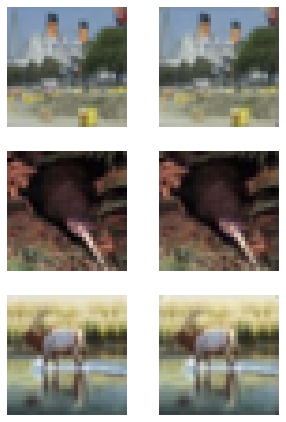

In [29]:
predict_examples(best_model)
plt.savefig(path + 'best.png')

## Part 3

Where we apply the architecture to an image colourization problem.

First, we try using the YCbCr colourspace (cf. Wikipedia) in order to represent the colour separately from the grayscale data. We will run into issues when using this for training, so we discard this method later.

In [30]:
def pixel_dot_product(rgb, v):
    return np.array([[np.dot(pixel, v) for pixel in row] for row in rgb])

def rgb2gray_1(rgb):
    colours = [rgb[...,0], rgb[...,1], rgb[...,2]]
    gray = sum(colours) / 3
    return gray

def rgb2gray_3(rgb):
    gray = rgb2gray_1(rgb)
    return merge((gray, gray, gray))

def rgb2y(rgb):
    return pixel_dot_product(rgb, [0.299, 0.587, 0.144])

def rgb2cb(rgb):
    return pixel_dot_product(rgb, [0.168736, 0.331264, 0.5])

def rgb2cr(rgb):
    return pixel_dot_product(rgb, [0.5, 0.418688, 0.081312])

def rgb2chroma(rgb):
    return merge((rgb2cb(rgb), rgb2cr(rgb)))

def merge(t):
    return np.dstack(t)

def gray_and_chroma2rgb(gray, chroma):
    y = gray
    cb, cr = chroma[...,0], chroma[...,1]
    ycbcr = merge((y, cb, cr))
    r = pixel_dot_product(ycbcr, [-2.58814, 0.178224, 3.48756])
    g = pixel_dot_product(ycbcr, [3.35251, -0.676629, -1.77646])
    b = pixel_dot_product(ycbcr, [-1.34771, 2.38814, -0.00000136212])
    return merge((r, g, b))

def convert(f, l, log=False):
    imgs = []
    i = 1
    for img in l:
        if log and i % math.ceil(len(l) / 5) == 0:
            print(str(i) + ' of ' + str(len(l)))
        imgs.append(f(img))
        i += 1
    return np.array(imgs)
    # return np.array([f(img) for img in l])

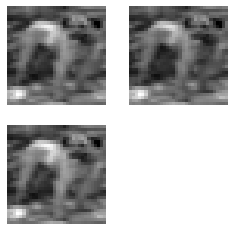

In [31]:
original = test[17]
gray, chroma = rgb2y(original), rgb2chroma(original)
there_and_back_again = gray_and_chroma2rgb(gray, chroma)
show([gray, chroma[...,0], chroma[...,1]])

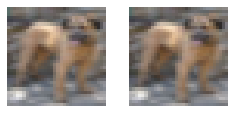

In [32]:
show([original, there_and_back_again])

So we see that this colourspace conversion works in principle. We thus create an accordingly modified dataset, where we take the grayscale data as inout __x__ and the colour data as output __y__.

In [ ]:
x_train_1, x_validation_1, x_test_1 = convert(rgb2gray_1, train, True), convert(rgb2gray_1, validation, True), convert(rgb2gray_1, test, True)
y_train_1, y_validation_1, y_test_1 = convert(rgb2chroma, train, True), convert(rgb2chroma, validation, True), convert(rgb2chroma, test, True)

In [ ]:
if retrain or True:
    gray_model_1 = make_model_with_config(
        input_layers=1,
        output_layers=2,
        fewer_layers=top_configuration['fewer_layers'], 
        channel_factor=top_configuration['channel_factor'], 
        kernel_size=top_configuration['kernel_size'],
        compression_factor=top_configuration['compression_factor']
    )
    gray_model_1.compile(
        loss=top_configuration['loss_metric'],
        metrics=['accuracy']
    )
    gray_model_1.fit(
        x_train_1,
        y_train_1, 
        epochs=100,
        validation_data=(x_validation_1, y_validation_1)
    )
    gray_model_1.save('gray_model_1')
else:
    gray_model_1 = keras.models.load('gray_model_1')

In [36]:
predicted_test_1 = gray_model_1.predict(x_test_1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


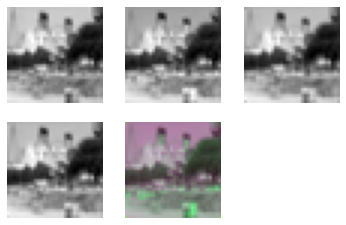

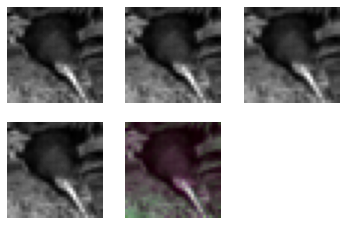

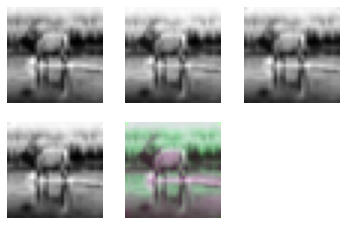

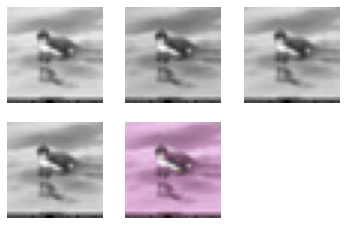

In [48]:
for i in range(4):
    show([y_test_1[i][...,0], y_test_1[i][...,1],
          predicted_test_1[i][...,0], predicted_test_1[i][...,1],
          gray_and_chroma2rgb(rgb2y(test[i]), predicted_test_1[i])])

Each picture corresponds to two rows: 
Cr, Cb, combined (original); 
Cr, Cb, combined (predicted).

Unfortunately, the results of using the chroma-separation approach are rather weird. 

Since we are not able to fix the difficulties with converting back the learned chrominance to RBG, we try a different approach:

First, we try what the quotient of the colours and the grayscale looks like.

In [38]:
def rgb2colour_quotient(rgb):
    colours = [rgb[...,0], rgb[...,1], rgb[...,2]]
    [r, g, b] = colours / sum(colours) * 256 / 3
    return merge((r, g, b))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


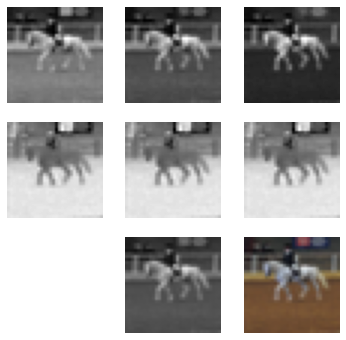

In [39]:
original = test[45]
converted = rgb2colour_quotient(original)
show([original[...,0], original[...,1], original[...,2],
      converted[...,0], converted[...,0], converted[...,0],
      converted, rgb2gray_3(original), rgb2gray_3(original) * converted / 256 * 9])

This representation is not too convincing. We therefore try the difference of the colour layers and the grayscale:

In [40]:
def rgb2colour_diff(rgb):
    colours = [rgb[...,0], rgb[...,1], rgb[...,2]]
    [r, g, b] = colours - sum(colours) /3
    return merge((r, g, b))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


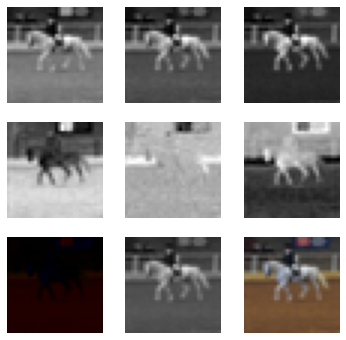

In [41]:
original = test[45]
converted = rgb2colour_diff(original)
show([original[...,0], original[...,1], original[...,2],
      converted[...,0], converted[...,1], converted[...,2],
      converted, rgb2gray_3(original), rgb2gray_3(original) + converted])

The difference between the colour layers and the gray image seems to be a much better representation than the quotient between them. 

So we create a new modified dataset based on the grayscale as input and the three colour differences as input.

In [42]:
x_train_2, x_validation_2, x_test_2 = convert(rgb2gray_1, train), convert(rgb2gray_1, validation), convert(rgb2gray_1, test)
y_train_2, y_validation_2, y_test_2 = convert(rgb2colour_diff, train), convert(rgb2colour_diff, validation), convert(rgb2colour_diff, test)

In [ ]:
if retrain or True:
    gray_model_2 = make_model_with_config(
        input_layers=1,
        output_layers=3,
        fewer_layers=top_configuration['fewer_layers'], 
        channel_factor=top_configuration['channel_factor'], 
        kernel_size=top_configuration['kernel_size'],
        compression_factor=top_configuration['compression_factor']
    )
    gray_model_2.compile(
        loss=top_configuration['loss_metric'],
        metrics=['accuracy']
    )
    gray_model_2.fit(
        x_train_2,
        y_train_2, 
        epochs=100,
        validation_data=(x_validation_2, y_validation_2)
    )
    gray_model_2.save('gray_model_2')
else:
    gray_model_2 = keras.models.load('gray_model_2')

In [44]:
predicted_test_2 = gray_model_2.predict(x_test_2)

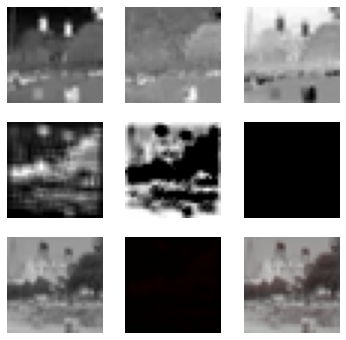

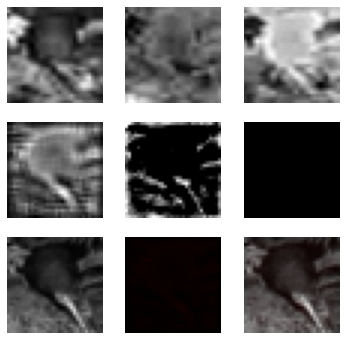

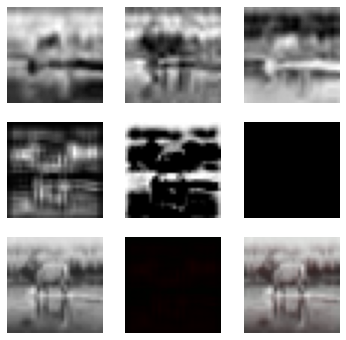

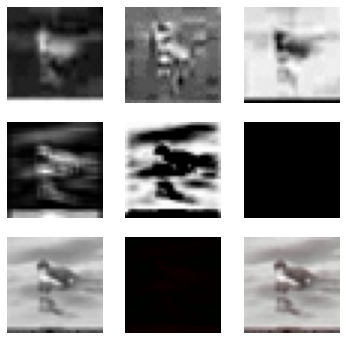

In [45]:
for i in range(4):
    show([y_test_2[i][...,0], y_test_2[i][...,1], y_test_2[i][...,2], 
          predicted_test_2[i][...,0], predicted_test_2[i][...,1], predicted_test_2[i][...,2],
          rgb2gray_3(test[i]), predicted_test_2[i], rgb2gray_3(test[i]) + predicted_test_2[i]])

Unfortunately, the result is still weird.

Resources used:

[1] https://keras.io/examples/vision/mnist_convnet/

[2] https://keras.io/examples/vision/image_classification_from_scratch/

[3] https://blog.keras.io/building-autoencoders-in-keras.html

